## Tabular Radiomcs evaluation

### 1. Imports

In [10]:
# standard
import pandas as pd
import numpy as np

# fastai
from fastai.tabular import TabularDataBunch, tabular_learner, accuracy, FillMissing, Categorify, Normalize, ClassificationInterpretation, DatasetType, TabularList

# personal
from src.utils import get_df_paths, calculate_age, get_df_dis, F_KEY, apply_cat, get_acc, plot_roc_curve, get_advanced_dis_df

# sklearn
from sklearn import tree, metrics
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# display
import matplotlib.pyplot as plt
from IPython.display import Image
import pydot

from fastai.callbacks import *
from fastai.metrics import roc_curve
from sklearn.metrics import auc

import radiomics
radiomics.__version__

'v3.0'

## Get datasets without radiomics -> Only age, location and gender dependent

In [3]:
def get_exp_keys(mode, dis):
    exp = pd.read_csv(f'{PATH}/{mode}-except.csv')
    exp_keys = exp.keys()
    exp = [exp[key][0] for key in exp_keys][1::]
    
    arr = dis[mode]['idx']

    new_arr = []
    for ele in arr:
        if ele in exp:
            continue
        new_arr.append(ele)
    
    dis[mode]['idx'] = new_arr
    return dis

In [4]:
df, _ = get_df_paths()
dis = get_advanced_dis_df(df)

PATH = 'radiomics'
REM_KEYS = ['Unnamed: 0', 'label2']
DEP_KEY = 'label1'

train = pd.read_csv(f'{PATH}/train.csv')
valid = pd.read_csv(f'{PATH}/valid.csv')
test = pd.read_csv(f'{PATH}/test.csv')

train = train.fillna(0).drop(columns=REM_KEYS)
valid = valid.fillna(0).drop(columns=REM_KEYS)
test = test.fillna(0).drop(columns=REM_KEYS)

dis = get_exp_keys('train', dis)
dis = get_exp_keys('valid', dis)
dis = get_exp_keys('test', dis)

train = train.fillna(0)
valid = valid.fillna(0)
test = test.fillna(0)

REM_KEYS = list(train.keys())
REM_KEYS.remove('label1')

In [5]:
ages = get_df_dis(df, out=False)
locs = df['Befundlokalisation']
gend = [name[0] for name in df[F_KEY]]
ent = df['Tumor.Entitaet']

train, valid, test = apply_cat(train, valid, test, dis, 'age', ages)
train, valid, test = apply_cat(train, valid, test, dis, 'loc', locs)
train, valid, test = apply_cat(train, valid, test, dis, 'gen', gend)

trainlen = len(train)
print(trainlen)
validlen = len(valid)
print(validlen)

# resulting valid indexes
valid_idx = range(trainlen, trainlen + validlen)

# build df
df_all = train.append(valid)
df_all = df_all.drop(columns=REM_KEYS)
df_train = train
df_test = test

# display df
df_all.head()

649
140


,label1,age,loc,gen
0,0,28,Oberarm,F
1,0,25,Oberarm,M
2,0,36,Unterarm,F
3,0,47,Unterarm,F
4,0,57,Becken,M


In [6]:
# Data Preparation
procs = [FillMissing, Categorify, Normalize]

# continous names
cont_names = list(train.keys())
contl = len(cont_names)
cont_names = cont_names[1:(contl)-5]

# categrorical names
cat_names = ['loc', 'gen', 'age']

# create databunch
data = TabularDataBunch.from_df(
    path=PATH, df=df_all, dep_var=DEP_KEY, valid_idx=valid_idx,
    cat_names=cat_names, cont_names=[], test_df=test, procs=procs)

data_test = TabularDataBunch.from_df(
    path=PATH, df=df_test, dep_var=DEP_KEY, valid_idx=[],
    cat_names= cat_names, cont_names=[], procs=procs)


data.test_ds.x = data_test.train_ds.x
data.test_ds.y = data_test.train_ds.y

# Show databunch
data.train_dl.num_workers = 0
data.train_dl.batch_size = 32
data.show_batch(rows=10)

loc,gen,age,target
Oberschenkel,M,43,1
Unterschenkel,M,15,0
Oberschenkel,M,17,1
Knie,M,16,0
Thoraxwand,M,38,0
Fuß,M,18,0
Huefte,M,54,0
Unterschenkel,F,51,1
Oberschenkel,M,16,0
Becken,M,77,0


In [8]:
learn = tabular_learner(data, layers=[200,100,100], metrics=accuracy)
learn.fit_one_cycle(10, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.759465,0.644174,0.728571,00:29
1,0.687329,0.609044,0.728571,00:28
2,0.640293,0.591532,0.728571,00:29
3,0.595358,0.546446,0.785714,00:29
4,0.549146,0.535981,0.742857,00:29
5,0.512045,0.559216,0.707143,00:29
6,0.472971,0.559419,0.707143,00:28
7,0.431241,0.569821,0.707143,00:28
8,0.398139,0.555759,0.707143,00:28
9,0.376880,0.559072,0.721429,00:29


Accuracy:  58.6 %
precision: 0.7156862745098039
sensitifity: 0.23684210526315788


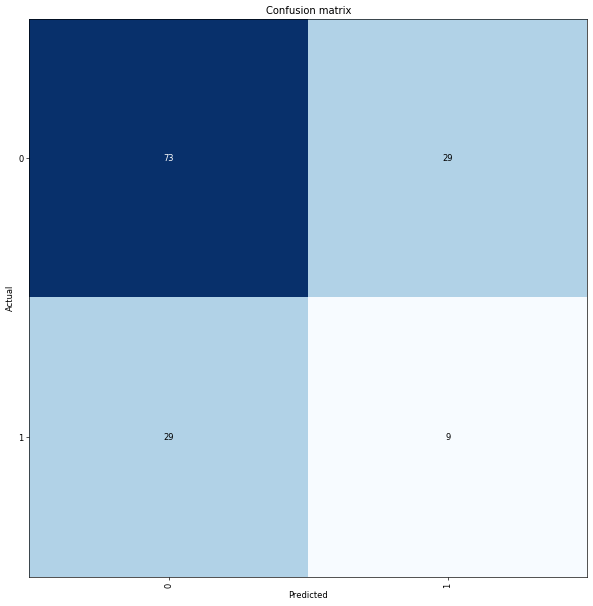

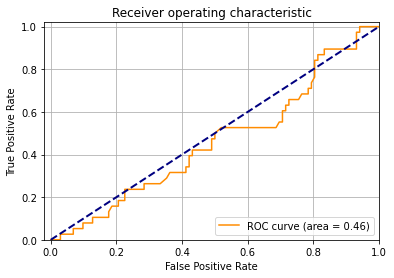

In [9]:
interp = ClassificationInterpretation.from_learner(learn, DatasetType.Test)
interp.plot_confusion_matrix(figsize=(10, 10), dpi=60)
print("Accuracy: ", round(100 * get_acc(interp), 1), "%")
plot_roc_curve(interp)

cm = interp.confusion_matrix()
precision = cm[0][0] / (cm[0][0] + cm[0][1])
sensitifity = cm[1][1] / (cm[1][0] + cm[1][1])
print(f'precision: {precision}')
print(f'sensitifity: {sensitifity}')